In [1]:
# Import relevant modules
import os
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras.layers as layers
from keras import callbacks
import keras
import uproot
from Sum import Sum
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
import pandas as pd
import hffrag
import keras_tuner as kt
from hffrag import fixedbinning
from hffrag import binneddensity


2022-11-23 17:39:28.925237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 17:39:29.080533: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-23 17:39:29.086143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-23 17:39:29.086156: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo


PDG ID: 531
number of b-hadrons: 13487

PDG ID: -521
number of b-hadrons: 61531

PDG ID: -511
number of b-hadrons: 61243

PDG ID: 5232
number of b-hadrons: 751

PDG ID: 511
number of b-hadrons: 61706

PDG ID: 521
number of b-hadrons: 61594

PDG ID: -531
number of b-hadrons: 13526

PDG ID: -5122
number of b-hadrons: 5447

PDG ID: 5122
number of b-hadrons: 5232

PDG ID: -5132
number of b-hadrons: 676

PDG ID: 5132
number of b-hadrons: 722

PDG ID: -5232
number of b-hadrons: 733

PDG ID: 555
number of b-hadrons: 3

PDG ID: 553
number of b-hadrons: 6

PDG ID: -5332
number of b-hadrons: 21

PDG ID: 5332
number of b-hadrons: 18

PDG ID: 100553
number of b-hadrons: 1

PDG ID: -541
number of b-hadrons: 5

PDG ID: 10551
number of b-hadrons: 3

PDG ID: 541
number of b-hadrons: 5

PDG ID: 20553
number of b-hadrons: 1



In [2]:
#A magic operator to allow Jupyter Notebooks to display matplotlib plots as outputs of cells
%matplotlib inline


In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")


In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000 # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 1e20 #This is the maximum number of events that will the program will accept
LR = 1e-2 #This is the default learning rate


In [5]:
# Find the associated tracks for each jet
def Match_Tracks(jets, tracks):
    """Used to determine if a set of tracks belong to a particular set of jets"""

    jet_eta = jets["AnalysisAntiKt4TruthJets_eta"]
    jet_phi = jets["AnalysisAntiKt4TruthJets_phi"] 

    tracks_eta = tracks["AnalysisTracks_eta"]
    tracks_phi = tracks["AnalysisTracks_phi"]

    delta_etas = jet_eta - tracks_eta
    delta_phis = np.abs(jet_phi - tracks_phi)

    # Map the phis from a cyclical period onto a linear relation
    ak.where(delta_phis > np.pi, delta_phis - np.pi, delta_phis)

    # Returns a list of true and false, determining which tracks belong to those jets.
    return np.sqrt(delta_phis**2 + delta_etas**2) < 0.4 


In [6]:
# Convert from cylindrical to cartesian coordinates
def pt_eta_phi_2_px_py_pz_jets(pt_eta_phi):
    """Converts the cylindrical polar coordinates to cartesian coordinates for jets"""

    # Seperate the pts, etas and phis
    pts = pt_eta_phi[:, 0:1]
    etas = pt_eta_phi[:, 1:2]
    phis = pt_eta_phi[:, 2:3]

    # Convert from polar to cartesian
    pxs = pts * np.cos(phis)
    pys = pts * np.sin(phis)
    pzs = pts * np.sinh(etas)

    # Check to see if there are any infinities
    isinf = np.isinf(pzs)

    if np.any(isinf):
        print("Infinities in eta detected!")
        print(etas[isinf])
        raise ValueError("Infinity from sinh(eta) has been detected")

    # Returns the momentum vector
    return np.concatenate([pxs, pys, pzs], axis=1)


In [7]:
def pt_eta_phi_2_px_py_pz_tracks(pt_eta_phi, MASKVAL=-999):
    """Converts the cylindrical polar coordinates to cartesian coordinates for jets"""

    # Seperate the pts, etas and phis
    pts = pt_eta_phi[:, :, 0:1]
    etas = pt_eta_phi[:, :, 1:2]
    phis = pt_eta_phi[:, :, 2:3]

    # Convert from polar to cartesian
    # Transforms only the non masked values from cylindrical to cartesian coordinates. Mask values are left unchanged.
    mask1 = pts == MASKVAL 
    mask2 = phis == MASKVAL
    mask3 = etas == MASKVAL
    pxs = np.where(mask1 | mask2, pts, pts * np.cos(phis)) 
    pys = np.where(mask1 | mask2, pts, pts * np.sin(phis))
    pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))

    # Check to see if there are any infinities
    isinf = np.isinf(pzs)

    if np.any(isinf):
        print("Infinities in eta detected!")
        print(etas[isinf])
        raise ValueError("Infinity from sinh(eta) has been detected")

    # Returns the momentum vector in cartesian coordinates
    return np.concatenate([pxs, pys, pzs], axis=2)


In [8]:
def pt_eta_phi2_px_py_pz_predicted_tracks(predictions):
    #Obtain the pts,etas and phis
    pts = predictions[:,0:1]
    etas = predictions[:,1:2]
    phis = predictions[:,2:3]

    # Convert from polar to cartesian
    # Transforms only the non masked values from cylindrical to cartesian coordinates. Mask values are left unchanged.
    pxs =  pts * np.cos(phis)
    pys =  pts * np.sin(phis)
    pzs =  pts * np.sinh(etas)

    # Check to see if there are any infinities
    isinf = np.isinf(pzs)

    if np.any(isinf):
        print("Infinities in eta detected!")
        print(etas[isinf])
        raise ValueError("Infinity from sinh(eta) has been detected")

    # Returns the momentum vector in cartesian coordinates
    return np.concatenate([pxs, pys, pzs], axis=-1)


In [9]:
def pad(x_values, maxsize, MASKVAL=-999):
    """
    Pads the inputs with nans to get to the maxsize
    """
    #Pad the non-regular arrays with null values until they are all of the same size. Then replace the nulls with MASVAL
    y_values = ak.fill_none(ak.pad_none(x_values, maxsize, axis=1, clip=True), MASKVAL)[:, :maxsize]
    return ak.to_regular(y_values, axis=1) #Return the regular arrays


In [10]:
def flatten(x_values, maxsize=-1, MASKVAL=-999):
    """"Pads the input to ensure they are all of regular size and then zips together result"""
    y_values = {} 
    for field in x_values.fields:
        z_values = x_values[field]
        if maxsize > 0:
            z_values = pad(z_values, maxsize, MASKVAL)
        y_values[field] = z_values

    return ak.zip(y_values)


In [11]:
def LogNormal_Loss_Function(true, meanscovs_matrix):
    """
    This is a loss function hand crafted for the task of ensuring the neural network 
    learns to predict the true value of the transverse momentum and it's uncertainty
    The logNormal constrains the neural network, by forcing upon it what it's output layers should be
    and what the weights and biases of the neural network will be in order to predict the means, variances and covariances
    """
    n_targets = np.shape(true)[1]
    # The first n_target of the features are the means
    means = meanscovs_matrix[:, :n_targets]
    # The second n_target of the feautres are the standard deviations
    logsigma = meanscovs_matrix[:, n_targets:2*n_targets]
    # The rest of the targets are the covariances
    logcosigma = meanscovs_matrix[:,2*n_targets:]

    loss = 0
    for n_target in range(n_targets): #Sum the individual losses and use that as the loss for the neural network
        loss += ((means[:, n_target] - true[:, n_target])**2) / (2 * keras.backend.exp(logsigma[:, n_target])**2) + logsigma[:, n_target]

    # Build loss function
    return loss

In [12]:
def Normal_Accuracy_Metric(true,meanscovs_matrix):
    """
    The primary function of the LogNormal loss function is to determine
    best normal distribution to fit to the bhadron data. By including the 
    uncertainity however, the metric is not so usefull for error checking. 
    I have added accuracy metric to better measure the ability of the neural 
    network to predict the correct values
    """
    # Determine the number of features we are predicting
    n_targets = np.shape(true)[1]
    
    # Extract the means of the features
    means = meanscovs_matrix[:,:n_targets]

    Accuracy = []
    for n_target in range(n_targets):
        Accuracy.append(abs((means[:,n_target]-true[:,n_target])/true[:,n_target])*100)
    Accuracy = tf.convert_to_tensor(Accuracy)
    return keras.backend.mean(Accuracy)

In [13]:
def LogNormal_Loss_Function_Check(true,meanscovs_matrix):
    """The role of this function is to calculate the loss for each individual b jet. This is used for the purpose of error checking"""
    n_targets = np.shape(true)[0]
    # Obtain data from convarience matrix
    means = meanscovs_matrix[0, :n_targets]
    # ensure diagonal is postive:
    logsigma = meanscovs_matrix[0, n_targets:2*n_targets]

    loss = []
    for n_target in range(n_targets):
        loss.append(((means[n_target] - true[n_target])**2) / (2 * keras.backend.exp(logsigma[n_target])**2) + logsigma[n_target])
    return loss

In [14]:
def expontial_decay(lr0,s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn
exponential_decay_fn = expontial_decay(lr0 = LR,s = 20)

In [15]:
def DeepSetNeuralNetwork(track_layers, jet_layers, n_targets,Learning_rate, MASKVAL=-999):
    """
    This function lays out the Deep Set Neural Architecture
    - A neural network is applied first to the tracks to extract information from the tracks.
    - This information produces an ensemble space which, the outputs of which are then summed to produce
        the inputs for the next layer
    - A neural network is then applied to the jet data obtained from the tracks. 
        To perform current univariate regression.
    """
    inputs = layers.Input(shape=(None, track_layers[0])) # Creates a layer for each input
    outputs = inputs  # Creates another layer to pass the inputs onto the ouputs
    outputs = layers.Masking(mask_value=MASKVAL)(outputs) # Masks the MASKVAl values

    counter = 0
    for nodes in track_layers[:-1]:
        #The first neural network is a series of dense layers and is applied to each track using the time distributed layer
        outputs = layers.TimeDistributed( 
            layers.Dense(nodes, activation="elu", kernel_initializer= "he_normal",kernel_regularizer = keras.regularizers.l2(0.01)))(outputs) # We use relu and the corresponding he_normal for the activation function and bias initializer
        if counter % 2 == 0: # Every two layers apply a dropout
            outputs = layers.Dropout(0.2)(outputs)
        else:
            counter += 1
        outputs = layers.BatchNormalization()(outputs) #Apply a batch norm to improve performance by preventing feature bias and overfitting

    outputs = layers.TimeDistributed(layers.Dense( 
        track_layers[-1], activation='softmax'))(outputs) # Apply softmax to ouput the results of the track neural network as probabilities
    outputs = Sum()(outputs) # Sum the outputs to make use of permutation invariance

    counter = 0
    for nodes in jet_layers: #Repeat of the track neural network without the need for the timedistributed layers
        outputs = layers.Dense(nodes, activation='elu', kernel_initializer= "he_normal",kernel_regularizer = keras.regularizers.l2(0.01))(outputs)
        if counter % 2 == 0:
            outputs = layers.Dropout(0.2)(outputs)
        else:
            counter += 1
        outputs = layers.BatchNormalization()(outputs)

    outputs = layers.Dense(n_targets+n_targets*(n_targets+1)//2)(outputs) # The output will have a number of neurons needed to form the mean covariance function of the loss func

    Model = keras.Model(inputs=inputs, outputs=outputs) #Create a keras model

    # Specify the neural network's optimizer and loss function
    Model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=Learning_rate,clipnorm = 1.0), # Optimizer used to train model
    metrics = [Normal_Accuracy_Metric], # Metric used to assess true performance of model
    loss=LogNormal_Loss_Function, #Loss function
    )

    return Model


In [16]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]


In [17]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features, entry_stop=MAXEVENTS)

In [18]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]


In [19]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [20]:
# Select tracks from the events
tracks = events[track_features]

# Match the tracks to the jets
matchedtracks = tracks[Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = flatten(matchedtracks, MAXTRACKS)

In [21]:
# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's ppredictions

There are 3 outputs
There are 32 inputs


In [22]:
print(np.shape(bhads)) #Check the shape of the neural network
print(np.shape(jet_features[:-1])) #Check for shape of the jet features
print(jets[jet_features[0]]) # Check the jets

(68143, 3)
(5,)
[1.48e+05, 1.04e+05, 1.16e+05, 4.03e+04, ... 8.14e+04, 9.83e+04, 1.45e+05, 9.11e+04]


In [23]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)
print(np.shape(jets))

(68143, 3)


In [24]:
#Check the matchtracks are the correct shape
print(matchedtracks[:, 0:1])
print(np.shape(matchedtracks[:, :, 3]))

[[[1.47e+04, 0.753, 1.14, 1.19, 75.5, ... -0.165, -0.51, -0.0283, -0.692, -0.038]]]
(68143, 32)


In [25]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
#bhads = pt_eta_phi_2_px_py_pz_jets(bhads)

#Check the shape of the momenta of the tracks and the rest of the data is consistent
print(np.shape(tracks_p))
print(np.shape(matchedtracks[:, :, 3:]))

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

(68143, 32, 3)
(68143, 32, 5)


/tmp/ipykernel_19841/1222727277.py:16: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [26]:
#Check that this is all the correct shape
print(np.shape(tracks))
print(tracks[0,0])
print(bhads[0])


(68143, 32, 8)
[6.20926450e+03 1.33553447e+04 1.21693980e+04 1.18753994e+00
 7.55359192e+01 1.33110714e+00 8.57456207e+01 1.32391548e+00]
[1.37346188e+05 8.16028237e-01 1.20712149e+00]


In [27]:
# Builds the deep neural network
track_layers = [32,32,32,32,32]
jet_layers = [64,64,64,64,64]
DeepNet = DeepSetNeuralNetwork(
    [len(track_features)]+track_layers, jet_layers,3, LR)


2022-11-23 17:41:16.302760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-23 17:41:16.302789: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-23 17:41:16.302805: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2022-11-23 17:41:16.303026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
#Summarises the Neural Network Architecture
DeepNet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking (Masking)           (None, None, 8)           0         
                                                                 
 time_distributed (TimeDistr  (None, None, 8)          72        
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, None, 8)           0         
                                                                 
 batch_normalization (BatchN  (None, None, 8)          32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 32)         288   

In [38]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks, bhads, train_size=0.7, random_state=42)
#Save the training and validation datasets.
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_train_data.npy",X_train)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_valid_data.npy",X_valid)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_train_data.npy",y_train)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_valid_data.npy",y_valid)

In [37]:
#Check for the of the training and validation sets
print(np.shape(X_valid), np.shape(y_valid))


(20443, 32, 8) (20443, 3)


In [31]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # The minimum amount of change to count as an improvement
    patience=15,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=20, min_lr=1e-6)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPoints/DeepNetWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_best_only=True)

# Learning Scheduler:
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)



In [32]:
# Train the neural network
history = DeepNet.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_learn_on_plateau,
               cp_callback, learning_scheduler]  # Enter call back
)


Epoch 1/1000
746/746 [==============================] - 12s 10ms/step - loss: 490738496.0000 - Normal_Accuracy_Metric: 248.5264 - val_loss: 15.7631 - val_Normal_Accuracy_Metric: 191.3133 - lr: 0.0100
Epoch 2/1000
746/746 [==============================] - 6s 9ms/step - loss: 12.8944 - Normal_Accuracy_Metric: 259.9258 - val_loss: 12.9418 - val_Normal_Accuracy_Metric: 158.4404 - lr: 0.0089
Epoch 3/1000
746/746 [==============================] - 6s 9ms/step - loss: 12.6904 - Normal_Accuracy_Metric: 186.9597 - val_loss: 13.5039 - val_Normal_Accuracy_Metric: 184.7588 - lr: 0.0079
Epoch 4/1000
746/746 [==============================] - 6s 9ms/step - loss: 12.5320 - Normal_Accuracy_Metric: 200.5511 - val_loss: 14.2408 - val_Normal_Accuracy_Metric: 210.3255 - lr: 0.0071
Epoch 5/1000
746/746 [==============================] - 6s 8ms/step - loss: 12.4041 - Normal_Accuracy_Metric: 219.2548 - val_loss: 18.3685 - val_Normal_Accuracy_Metric: 241.9577 - lr: 0.0063
Epoch 6/1000
746/746 [==============

<AxesSubplot:>

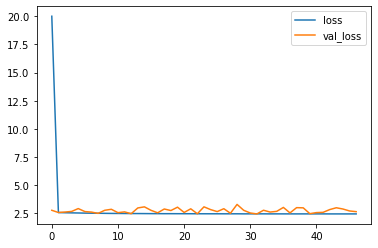

In [33]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss", "val_loss"]]).plot()


In [34]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["val_loss"].min()))

Minimum validation loss: 11.4197416305542


In [35]:
#Predict the momentas for a single jet and determine the loss
print(DeepNet.predict(tracks[:1]))
print(bhads[0])

# Calculate the individual loss for each feature
LogNormal_Loss_Function_Check(bhads[0],DeepNet.predict(tracks[0]))

1/1 [==============================] - 0s 304ms/step
[[ 2.5968558e+02  5.7332975e-01  1.3555371e+00  1.1466875e+01
  -1.2017314e+00 -1.0263433e+00  2.6716202e-01 -2.2726102e-01
   3.3133459e-01]]
[1.37346188e+05 8.16028237e-01 1.20712149e+00]
1/1 [==============================] - 0s 304ms/step


[<tf.Tensor: shape=(), dtype=float32, numpy=12.497163>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.87595844>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.9405606>]

In [36]:
#Evaluate the entire performance of the model
loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
print("The Loaded DeepNet has loss: ", loss,3)

2130/2130 - 3s - loss: 11.4325 - Normal_Accuracy_Metric: 106.1589 - 3s/epoch - 1ms/step
The Loaded DeepNet has loss:  [11.432482719421387, 106.15887451171875] 3
